In [1]:
import gdown
import os
import pandas as pd
import numpy as np

# from google.colab import files
# uploaded = files.upload()

# sp500_df = pd.read_csv('sp500_dataframe.csv')
# sp500_df.head()

# file share for the companies Dataset: https://drive.google.com/file/d/154LPFNKqEr4Pgz1nwDaCG_b9ZK4P2yVH/view?usp=sharing

file_id_comp = "154LPFNKqEr4Pgz1nwDaCG_b9ZK4P2yVH"
output_file_comp = "sp500_companies.csv"

if not os.path.exists(output_file_comp):
    gdown.download(f"https://drive.google.com/uc?id={file_id_comp}&confirm=t", output_file_comp, quiet=False)

sp500 = pd.read_csv(output_file_comp)
sp500.head()

# file share for the processed Dataset: https://drive.google.com/file/d/1TFyUlcB8PbMokVsdB0ZtYzadYnhUJWNN/view?usp=sharing

file_id_df = "1TFyUlcB8PbMokVsdB0ZtYzadYnhUJWNN"
output_file_df = "sp500_dataframe.csv"

if not os.path.exists(output_file_df):
    gdown.download(f"https://drive.google.com/uc?id={file_id_df}&confirm=t", output_file_df, quiet=False)

sp500_df = pd.read_csv(output_file_df)
sp500_df.head()

sp500_tickers = sp500['Symbol'].tolist()
sp500_df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

# Remove numeric index and repalce with the date

sp500_df.set_index("Date", inplace=True)
sp500_df.index.name = None

# Remove tickers row
sp500_df = sp500_df.drop(sp500_df.index[0])
# Remove the date row
sp500_df = sp500_df.drop(sp500_df.index[1])
# Remove the price row
sp500_df = sp500_df.drop(sp500_df.index[2])
sp500_df = sp500_df.drop(sp500_df.index[0])

data = sp500_df.iloc[:, 1:].to_numpy()
n_things = data.shape[1] // 9

reshapedd = data.reshape(data.shape[0], n_things, 9)

final_array = reshapedd.transpose(1, 0, 2)
final_array = final_array[:, :260, :]
final_array = np.array(final_array, dtype=np.float64)

final_array = final_array[~np.isnan(final_array).any(axis=(1, 2))]
final_array.shape

<ipython-input-1-92a17a1410b3>:31: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,26

(423, 260, 9)

In [58]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

X = final_array[:, :247, :5]  # Features (companies, weeks, features)
y = final_array[:, 247:, :1]  # Target (companies, weeks, 1 feature - Close)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_minmax = MinMaxScaler()
y_minmax = MinMaxScaler()

X_train_scaled = X_minmax.fit_transform(X_train.reshape(-1, X_train.shape[2]))
X_train_scaled = X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])

y_train_scaled = y_minmax.fit_transform(y_train.reshape(-1, 1))
y_train_scaled = y_train_scaled.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2])

print(X_train_scaled.shape)
print(y_train_scaled.shape)

X_train_tensor = torch.from_numpy(X_train_scaled).float()  # Convert to float32
y_train_tensor = torch.from_numpy(y_train_scaled).float()  # Convert to float32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

(338, 247, 5)
(338, 13, 1)


In [59]:
import torch
import torch.nn as nn

class GRUSeqPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, forecast_steps=13):
        """
        Args:
            input_dim (int): Number of features in the input (e.g., 9).
            hidden_dim (int): Hidden state dimension.
            layer_dim (int): Number of GRU layers.
            output_dim (int): Number of features in the output (e.g., 1 for close price).
            forecast_steps (int): How many time steps to predict (e.g., 13 weeks).
        """
        super(GRUSeqPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.forecast_steps = forecast_steps
        self.encoder = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.decoder = nn.GRU(output_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.layer_dim, batch_size, self.hidden_dim).to(x.device)
        _, hidden = self.encoder(x, h0)

        decoder_input = torch.zeros(batch_size, 1, self.fc.out_features).to(x.device)
        outputs = []

        for _ in range(self.forecast_steps):
            decoder_output, hidden = self.decoder(decoder_input, hidden)
            pred = self.fc(decoder_output)
            outputs.append(pred)
            decoder_input = pred

        outputs = torch.cat(outputs, dim=1)
        return outputs

In [75]:
input_dim = 5       # 9 features in input
hidden_dim = 100
layer_dim = 3
output_dim = 1      # Predict one feature (close)
forecast_steps = 13
num_epochs = 50
batch_size = 32
learning_rate = 0.01


# Create dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Instantiate model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUSeqPredictor(input_dim, hidden_dim, layer_dim, output_dim, forecast_steps).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        # Forward pass: model returns predictions of shape (batch, 13, 1)
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_X.size(0)

    epoch_loss /= len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training complete.")

Epoch [1/50], Loss: 0.0830
Epoch [2/50], Loss: 0.0045


KeyboardInterrupt: 

(13, 1)
tensor([[[1.6975e-02, 1.8583e-02, 1.7571e-02, 7.2417e-09, 8.1880e-03],
         [1.8782e-02, 2.0060e-02, 1.9039e-02, 7.7880e-09, 1.5505e-02],
         [1.9292e-02, 2.0747e-02, 1.9631e-02, 8.0835e-09, 1.1672e-02],
         ...,
         [3.2502e-02, 3.6118e-02, 3.3045e-02, 1.3979e-08, 1.1262e-02],
         [3.4626e-02, 3.7224e-02, 3.3100e-02, 1.3608e-08, 1.0722e-02],
         [3.5237e-02, 3.8032e-02, 3.5653e-02, 1.4498e-08, 1.0187e-02]]])
[ 67.47000122  74.59999847  76.61000061  81.94999695  78.69000244
  78.44999695  78.70999908  78.05999756  76.25        70.29000092
  70.38999939  72.44000244  72.94999695  73.52999878  73.44999695
  72.01000214  73.13999939  70.01000214  68.91999817  74.88999939
  75.86000061  76.51999664  76.19999695  76.12000275  74.76999664
  68.38999939  67.94999695  69.11000061  72.13999939  69.26999664
  63.52000046  62.74000168  63.88999939  66.27999878  67.48999786
  71.47000122  72.95999908  74.15000153  77.23000336  76.44999695
  74.43000031  79.5500

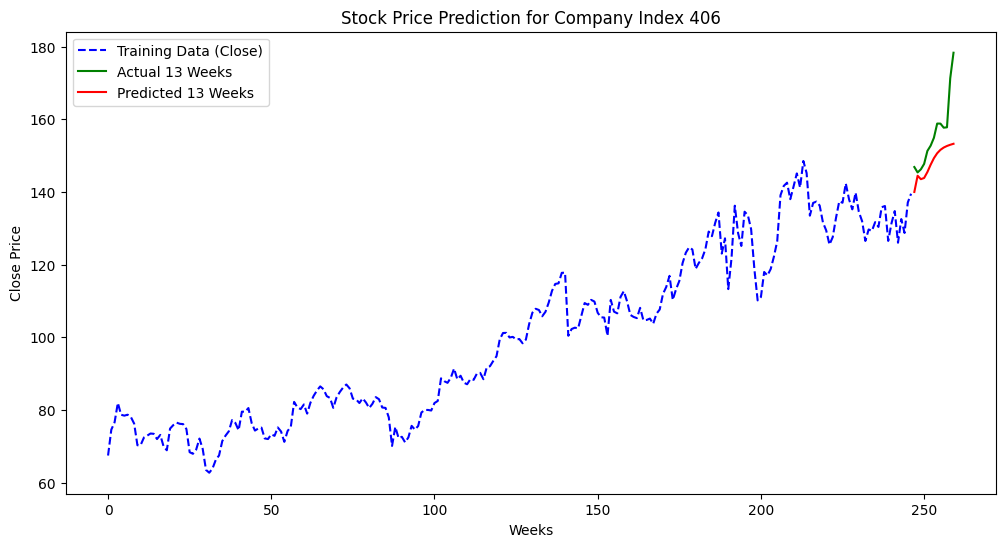

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch

# Get a random company's data
random_company_index = random.randint(0, final_array.shape[0] - 1)
X_company = final_array[random_company_index, :247, :5].reshape(1, 247, 5)  # Use all 9 features
y_company = final_array[random_company_index, 247:, 0].reshape(-1, 1)  # Use 'Close' price for target
print(y_company.shape)
# Scale the company's data
X_company_scaled = X_minmax.transform(X_company.reshape(-1, X_company.shape[2]))
X_company_scaled = X_company_scaled.reshape(X_company.shape[0], X_company.shape[1], X_company.shape[2])

X_company_tensor = torch.from_numpy(X_company_scaled).float().to(device)

# Make predictions using the trained model
print(X_company_tensor)
model.eval()
with torch.no_grad():
    predictions = model(X_company_tensor)

# Inverse transform the predictions to get actual values
predictions = predictions.cpu().numpy()
predictions = y_minmax.inverse_transform(predictions.reshape(-1, 1))
predictions = predictions.reshape(1, -1)


plt.figure(figsize=(12, 6))

# Plot training data (last 247 weeks)
plt.plot(range(X_company.shape[1]), X_company[0, :, 0], label="Training Data (Close)", linestyle="--", color="blue")  # Plot 'Close' price

# Plot actual 13 weeks data
plt.plot(range(X_company.shape[1], X_company.shape[1] + y_company.shape[0]), y_company[:, 0], label="Actual 13 Weeks", color="green")

# Plot predicted 13 weeks data
plt.plot(range(X_company.shape[1], X_company.shape[1] + y_company.shape[0]), predictions[0, :], label="Predicted 13 Weeks", color="red")

print(X_company[0, :, 0])
print(y_company)
print(predictions)
plt.title(f"Stock Price Prediction for Company Index {random_company_index}")
plt.xlabel("Weeks")
plt.ylabel("Close Price")
plt.legend()
plt.show()